In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

In [98]:
# Installing packages
!pip install pmdarima

In [99]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import itertools

In [100]:
data=pd.read_csv("..//input_data/Electricity Consumption.csv")

In [101]:
data.head

<bound method NDFrame.head of          DATE  Electricty_Consumption_in_TW
0    1/1/1973                       35.9728
1    2/1/1973                       36.1334
2    3/1/1973                       35.0625
3    4/1/1973                       33.8416
4    5/1/1973                       33.5107
..        ...                           ...
556  5/1/2019                       97.5860
557  6/1/2019                      110.8580
558  7/1/2019                      122.1014
559  8/1/2019                      121.7765
560  9/1/2019                      109.7190

[561 rows x 2 columns]>

In [102]:
data.info

<bound method DataFrame.info of          DATE  Electricty_Consumption_in_TW
0    1/1/1973                       35.9728
1    2/1/1973                       36.1334
2    3/1/1973                       35.0625
3    4/1/1973                       33.8416
4    5/1/1973                       33.5107
..        ...                           ...
556  5/1/2019                       97.5860
557  6/1/2019                      110.8580
558  7/1/2019                      122.1014
559  8/1/2019                      121.7765
560  9/1/2019                      109.7190

[561 rows x 2 columns]>

In [103]:
data.columns

Index(['DATE', 'Electricty_Consumption_in_TW'], dtype='object')

In [104]:
data['DATE'] = pd.to_datetime(data['DATE'])

In [105]:
# Transform "DATA" column into index
data.set_index('DATE', inplace=True)
data

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014


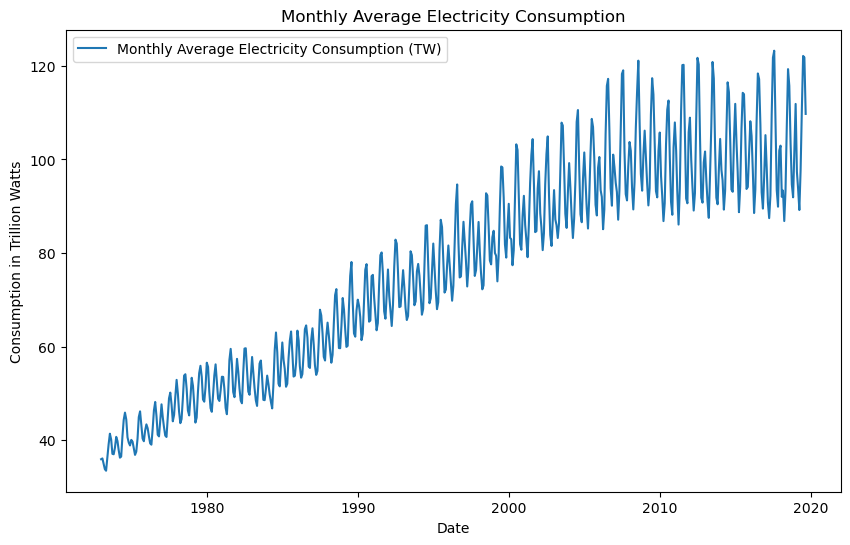

In [106]:
# View the data
plt.figure(figsize=(10, 6))
plt.plot(data, label='Monthly Average Electricity Consumption (TW)')
plt.title('Monthly Average Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption in Trillion Watts')
plt.legend()
plt.show()

#  Monthly Average Electricity Consumption
The graph illustrates the monthly average electricity consumption over a span of several decades, from the 1970s to around 2020. Here are the key components and insights from the graph:
Key Components:

X-axis (Date):

The x-axis represents the timeline from the 1970s to around 2020.
Each point on the x-axis corresponds to a month within this time frame.

Y-axis (Consumption in Trillion Watts):

The y-axis measures the monthly average electricity consumption in trillion watts (TW).
The values range from approximately 40 TW to over 120 TW.

Line Plot:

The blue line represents the monthly average electricity consumption.
The line shows the trend and seasonal patterns in electricity consumption over time.

Observations:

Overall Trend:

There is a clear upward trend in electricity consumption from the 1970s to 2020.
This indicates a general increase in electricity usage over the decades, likely due to population growth, industrialization, and increased use of electronic devices.

Seasonal Variation:

The graph exhibits regular fluctuations within each year, indicating seasonal variation in electricity consumption.
Peaks and troughs can be observed, which may correspond to higher consumption during winter and summer months due to heating and cooling needs.

Significant Events:

There are some noticeable spikes and drops that deviate from the overall trend.
These could be due to significant events such as economic crises, policy changes, or extraordinary weather conditions affecting electricity consumption.

Summary:

This graph provides a comprehensive view of the historical patterns in monthly average electricity consumption. It highlights the overall increase in consumption over the years, as well as the consistent seasonal variations. Understanding these patterns is crucial for energy planning, policy-making, and forecasting future electricity demand.


### Outlier Treatment

<Axes: >

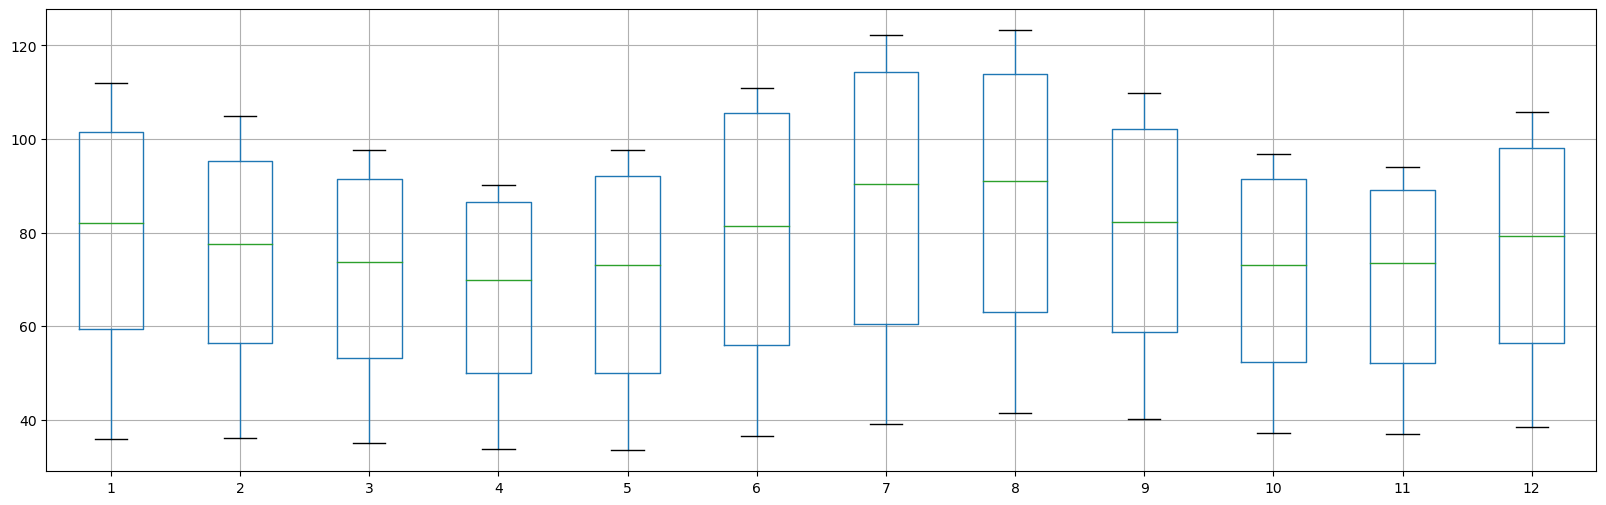

In [107]:
plt.figure(figsize=(20,6))
data.pivot_table(values = 'Electricty_Consumption_in_TW',
                 columns = data.index.month, 
                 index = data.index.year).boxplot()

### Decomposition

In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 1973-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1)
memory usage: 8.8 KB


### Splitting data into Train and Test

In [109]:
train=data[:393]

In [110]:
decompose = sm.tsa.seasonal_decompose(train, model='multiplicative',
                                     two_sided=False, extrapolate_trend=4)

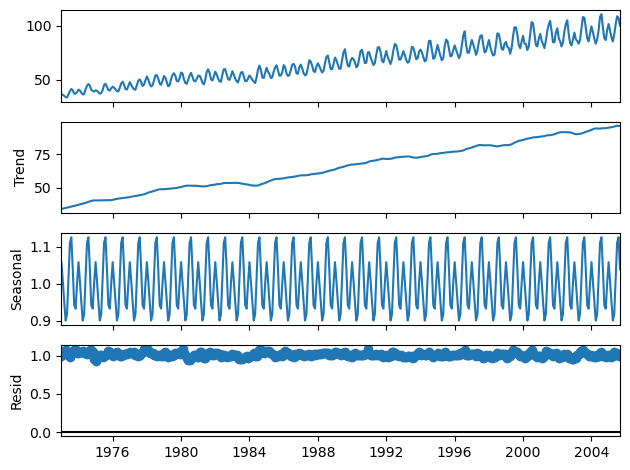

In [111]:
decompose.plot();

In [112]:
decompose_output1 = pd.DataFrame(pd.concat([decompose.observed,decompose.trend,decompose.seasonal,decompose.resid],axis=1))
decompose_output1.columns=['observed','Trend','Seasonal','Irregular']
decompose_output1['Recalculated_Demand'] = decompose_output1.Trend*decompose_output1.Seasonal*decompose_output1.Irregular
decompose_output1

,observed,Trend,Seasonal,Irregular,Recalculated_Demand
DATE,,,,,
1973-01-01,35.9728,34.092018,1.058014,0.997310,35.9728
1973-02-01,36.1334,34.357224,1.005567,1.045874,36.1334
1973-03-01,35.0625,34.622430,0.953498,1.062100,35.0625
1973-04-01,33.8416,34.887636,0.900317,1.077417,33.8416
1973-05-01,33.5107,35.152842,0.916865,1.039723,33.5107
...,...,...,...,...,...
2005-05-01,91.8307,95.340454,0.916865,1.050522,91.8307
2005-06-01,101.3472,95.769579,1.016946,1.040606,101.3472
2005-07-01,108.6568,96.038425,1.109943,1.019321,108.6568


In [113]:
decompose_output1['Time_Index']=pd.Series(np.array( range( 1, 394, 1 ) )).values

In [114]:
decompose_output1.head(2)

,observed,Trend,Seasonal,Irregular,Recalculated_Demand,Time_Index
DATE,,,,,,
1973-01-01,35.9728,34.092018,1.058014,0.997310,35.9728,1
1973-02-01,36.1334,34.357224,1.005567,1.045874,36.1334,2


<Axes: xlabel='Time_Index'>

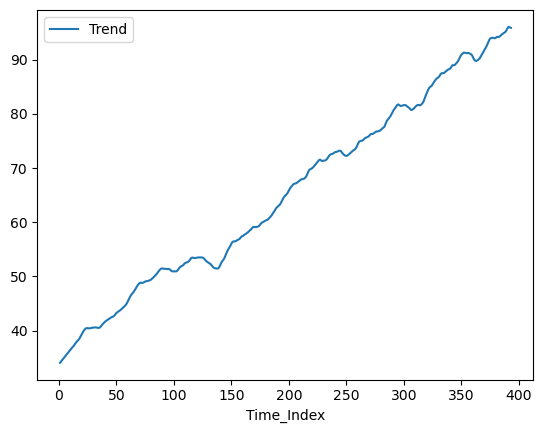

In [115]:
decompose_output1.plot(y='Trend',x='Time_Index')

In [116]:
d = np.polyfit(decompose_output1['Time_Index'],decompose_output1['Trend'],1)
f = np.poly1d(d)

In [117]:
from sympy import Symbol,expand

In [118]:
x=Symbol('x')
print(expand(f(x)))

0.153134336726621*x + 35.1375537331338


In [119]:
decompose_output1.Irregular.mean()

1.0157377837767632

In [120]:
test=data[-168:]

In [121]:
decompose_output2=pd.DataFrame()

In [122]:
decompose_output2.index=test.index

In [123]:
decompose_output2['Seasonal']=decompose_output1.Seasonal[9:177].values

In [124]:
decompose_output2['Time_Index']=pd.Series(np.array( range( 394, 562, 1 ) )).values

In [125]:
decompose_output2['Trend']=(0.153134336726621*(decompose_output2.Time_Index) + 35.1375537331338)

In [126]:
decompose_output2['Irregular']=decompose_output1.Irregular.mean()

In [127]:
decompose_output2['Test_Pred']=(decompose_output2.Seasonal*decompose_output2.Trend*decompose_output2.Irregular)
decompose_output2

,Seasonal,Time_Index,Trend,Irregular,Test_Pred
DATE,,,,,
2005-10-01,0.941739,394,95.472482,1.015738,91.325127
2005-11-01,0.932422,395,95.625617,1.015738,90.566704
2005-12-01,1.000887,396,95.778751,1.015738,97.372429
2006-01-01,1.058014,397,95.931885,1.015738,103.094624
2006-02-01,1.005567,398,96.085020,1.015738,98.140550
...,...,...,...,...,...
2019-05-01,0.916865,557,120.433379,1.015738,112.158951
2019-06-01,1.016946,558,120.586514,1.015738,124.559858
2019-07-01,1.109943,559,120.739648,1.015738,136.123262


### Evaluation

In [128]:
RMSE_train = round(np.sqrt( mean_squared_error( decompose_output1.observed, decompose_output1.Recalculated_Demand )),2)
RMSE_test = round(np.sqrt( mean_squared_error( test.Electricty_Consumption_in_TW, decompose_output2.Test_Pred )),2)

RMSPE_train = round(np.sqrt( np.mean(np.square(((decompose_output1.observed - decompose_output1.Recalculated_Demand) / decompose_output1.observed)), axis=0)),2)
RMSPE_test = round(np.sqrt( np.mean(np.square(((test.Electricty_Consumption_in_TW - decompose_output2.Test_Pred) / test.Electricty_Consumption_in_TW)), axis=0)),2)

MAPE_train = round(mean_absolute_percentage_error( decompose_output1.observed, decompose_output1.Recalculated_Demand ), 2)
MAPE_test = round(mean_absolute_percentage_error( test.Electricty_Consumption_in_TW, decompose_output2.Test_Pred ), 2)

print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)
print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

RMSE of training data:  0.0  |  RMSE of testing data:  11.76
RMSPE of training data:  0.0  |  RMSPE of testing data:  0.12
MAPE of training data:  0.0  |  MAPE of testing data:  0.1


## Prediction

In [129]:
decompose_output3=pd.DataFrame()
decompose_output3.index=(decompose_output2.index[-27:].shift(28,freq='MS')+ pd.DateOffset( day = 1 ))
decompose_output3['Time_Index']=pd.Series(np.array( range( 562,589, 1 ) )).values

C:\Users\DELL\AppData\Local\Temp\ipykernel_18080\3057735539.py:2: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  decompose_output3.index=(decompose_output2.index[-27:].shift(28,freq='MS')+ pd.DateOffset( day = 1 ))


In [130]:
decompose_output3['Seasonal']=decompose_output1.Seasonal.iloc[9:36].values
decompose_output3['Trend']=(0.153134336726621*(decompose_output3.Time_Index) + 35.1375537331338)
decompose_output3['Irregular']=decompose_output1.Irregular.mean()
decompose_output3['Pred']=(decompose_output3.Seasonal*decompose_output3.Trend*decompose_output3.Irregular)
decompose_output3

,Time_Index,Seasonal,Trend,Irregular,Pred
DATE,,,,,
2019-11-01,562,0.941739,121.199051,1.015738,115.934125
2019-12-01,563,0.932422,121.352185,1.015738,114.932252
2020-01-01,564,1.000887,121.505320,1.015738,123.527066
2020-02-01,565,1.058014,121.658454,1.015738,130.742063
2020-03-01,566,1.005567,121.811588,1.015738,124.417482
2020-04-01,567,0.953498,121.964723,1.015738,118.123346
2020-05-01,568,0.900317,122.117857,1.015738,111.675132
2020-06-01,569,0.916865,122.270991,1.015738,113.870309
2020-07-01,570,1.016946,122.424126,1.015738,126.458020


### ETS Model

In [131]:
hwmodel=ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=12).fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [132]:
train_pred=hwmodel.predict(0)

In [133]:
train_pred

1973-01-01     36.682735
1973-02-01     35.083278
1973-03-01     33.529791
1973-04-01     32.518302
1973-05-01     33.108805
                 ...    
2005-05-01     90.104975
2005-06-01    101.292086
2005-07-01    111.783193
2005-08-01    111.354900
2005-09-01     97.909726
Freq: MS, Length: 393, dtype: float64

In [134]:
test_pred=hwmodel.forecast(168)

In [135]:
test_pred

2005-10-01     88.947344
2005-11-01     87.243108
2005-12-01     95.447774
2006-01-01    101.086047
2006-02-01     94.509124
                 ...    
2019-05-01    115.414772
2019-06-01    127.974334
2019-07-01    140.061878
2019-08-01    140.756560
2019-09-01    127.279048
Freq: MS, Length: 168, dtype: float64

## Evaluation

In [136]:
RMSE_train = round(np.sqrt( mean_squared_error( decompose_output1.observed, train_pred )),2)
RMSE_test = round(np.sqrt( mean_squared_error( test.Electricty_Consumption_in_TW, test_pred )),2)

RMSPE_train = round(np.sqrt( np.mean(np.square(((decompose_output1.observed - train_pred) / decompose_output1.observed)), axis=0)),2)
RMSPE_test = round(np.sqrt( np.mean(np.square(((test.Electricty_Consumption_in_TW - test_pred) / test.Electricty_Consumption_in_TW)), axis=0)),2)

MAPE_train = round(mean_absolute_percentage_error( decompose_output1.observed, train_pred ), 2)
MAPE_test = round(mean_absolute_percentage_error( test.Electricty_Consumption_in_TW, test_pred ), 2)

print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)
print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

RMSE of training data:  1.46  |  RMSE of testing data:  11.37
RMSPE of training data:  0.02  |  RMSPE of testing data:  0.11
MAPE of training data:  0.02  |  MAPE of testing data:  0.09


### Prediction

In [137]:
predict=ExponentialSmoothing(data,trend='add',seasonal='mul',seasonal_periods=12).fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [138]:
predict.forecast(27)

2019-10-01     97.038327
2019-11-01     94.752127
2019-12-01    105.279781
2020-01-01    112.034228
2020-02-01    102.196993
2020-03-01     98.960061
2020-04-01     92.885439
2020-05-01     99.409240
2020-06-01    113.930480
2020-07-01    125.483149
2020-08-01    124.167570
2020-09-01    111.076163
2020-10-01     98.667032
2020-11-01     96.340239
2020-12-01    107.041883
2021-01-01    113.906770
2021-02-01    103.902738
2021-03-01    100.609486
2021-04-01     94.431467
2021-05-01    101.061562
2021-06-01    115.821546
2021-07-01    127.563094
2021-08-01    126.222869
2021-09-01    112.912232
2021-10-01    100.295738
2021-11-01     97.928351
2021-12-01    108.803984
Freq: MS, dtype: float64

## Dickey-Fuller Test

In [139]:
adfuller(data)

(-1.7405933729832546,
 0.41032816044686277,
 15,
 545,
 {'1%': -3.442405720052601,
  '5%': -2.866857804790472,
  '10%': -2.5696022094099824},
 2295.409663118043)

Since the value of p is high, we accept the null hypothesis, that is the data is not stationary. Also, since there is seasonality in the data, we go with SARIMA Model

Making the data Stationary

Taking Log10

In [140]:
data_log = np.log10(data)

print('Results of Dickey-Fuller Test:')
dftest = adfuller(data_log)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -3.001867
p-value                          0.034720
#lags Used                      15.000000
Number of Observations Used    545.000000
Critical Value (1%)             -3.442406
Critical Value (5%)             -2.866858
Critical Value (10%)            -2.569602
dtype: float64


In [141]:
train_log=np.log10(train)

The data has been made Stationary.

In [142]:
p = q = range(0, 3)
d = range(2,3)
pdq = list(itertools.product(p, d, q))

In [143]:
D = range(0,2)
P = Q = range(0, 2) 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

In [144]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_log,
                                             order = param,
                                             seasonal_order = param_seasonal,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            #print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self.

Best SARIMAX(2, 2, 2)x(1, 0, 1, 12)12 model - AIC:-2488.7804161364156


In [145]:
best_model=sm.tsa.statespace.SARIMAX(train_log,
                                      order=(2, 2, 2),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [146]:
train_predict=10**(best_results.predict(start='1973-01-01',end='2005-09-01'))

In [147]:
test_predict=10**(best_results.forecast(168))

In [148]:
RMSE_train = round(np.sqrt( mean_squared_error( decompose_output1.observed, train_predict )),2)
RMSE_test = round(np.sqrt( mean_squared_error( test.Electricty_Consumption_in_TW, test_predict )),2)

RMSPE_train = round(np.sqrt( np.mean(np.square(((decompose_output1.observed - train_predict) / decompose_output1.observed)), axis=0)),2)
RMSPE_test = round(np.sqrt( np.mean(np.square(((test.Electricty_Consumption_in_TW - test_predict) / test.Electricty_Consumption_in_TW)), axis=0)),2)

MAPE_train = round(mean_absolute_percentage_error( decompose_output1.observed, train_predict ), 2)
MAPE_test = round(mean_absolute_percentage_error( test.Electricty_Consumption_in_TW, test_predict ), 2)

print('RMSE of training data: ', RMSE_train,  ' | ', 'RMSE of testing data: ', RMSE_test)
print('RMSPE of training data: ', RMSPE_train,  ' | ', 'RMSPE of testing data: ', RMSPE_test)
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

RMSE of training data:  32.77  |  RMSE of testing data:  4.3
RMSPE of training data:  0.91  |  RMSPE of testing data:  0.04
MAPE of training data:  0.07  |  MAPE of testing data:  0.04


### Prediction

In [149]:
best_model=sm.tsa.statespace.SARIMAX(data_log,
                                      order=(2, 2, 2),
                                      seasonal_order=(0, 1, 1, 12),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False)
best_results = best_model.fit()

C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [150]:
prediction=10**(best_results.forecast(27))

In [151]:
prediction

2019-10-01     97.463669
2019-11-01     94.982420
2019-12-01    105.124305
2020-01-01    111.500152
2020-02-01    101.920059
2020-03-01     97.768663
2020-04-01     91.732267
2020-05-01     98.121586
2020-06-01    112.625593
2020-07-01    124.050363
2020-08-01    123.033932
2020-09-01    110.358048
2020-10-01     97.997588
2020-11-01     95.603058
2020-12-01    105.722282
2021-01-01    112.155817
2021-02-01    102.506653
2021-03-01     98.318821
2021-04-01     92.243287
2021-05-01     98.657748
2021-06-01    113.231233
2021-07-01    124.706309
2021-08-01    123.673189
2021-09-01    110.921542
2021-10-01     98.489071
2021-11-01     96.073878
2021-12-01    106.233373
Freq: MS, Name: predicted_mean, dtype: float64

#### Decomposition model is overfit. Selecting ETS Model, since it has least error overall in comparison to SARIMA